<a href="https://colab.research.google.com/github/Praveengovianalytics/50DaysofRecomSystem/blob/main/Day_8_Collabrative_Filtering_ALS_recommendation_systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#50DaysofRecommendationSystems - Day 8

<a id='CBRS'></a>
# Collabrative filtering Recommender System - ALS


Let us understand this with an example. If person A likes 3 movies, say Interstellar, Inception and Predestination, and person B likes Inception, Predestination and The Prestige, then they have almost similar interests. We can say with some certainty that A should like The Prestige and B should like Interstellar. The collaborative filtering algorithm uses “User Behavior” for recommending items. This is one of the most commonly used algorithms in the industry as it is not dependent on any additional information. There are different types of collaborating filtering techniques and we shall look at them in detail below. 


### User-User collaborative filtering

This algorithm first finds the similarity score between users. Based on this similarity score, it then picks out the most similar users and recommends products which these similar users have liked or bought previously.


In terms of our movies example from earlier, this algorithm finds the similarity between each user based on the ratings they have previously given to different movies. The prediction of an item for a user u is calculated by computing the weighted sum of the user ratings given by other users to an item i.


### Item-Item collaborative filtering

In this algorithm, we compute the similarity between each pair of items.

So in our case we will find the similarity between each movie pair and based on that, we will recommend similar movies which are liked by the users in the past. This algorithm works similar to user-user collaborative filtering with just a little change – instead of taking the weighted sum of ratings of “user-neighbors”, we take the weighted sum of ratings of “item-neighbors”. 

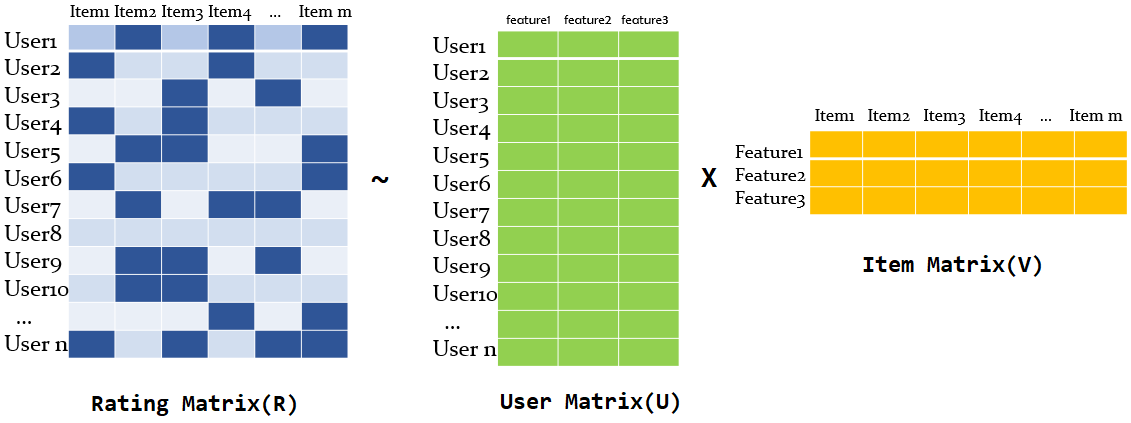

ALS (Alternating Least Squares) is an implicit recommendation algorithm to make a recommendation of products and product categories to the users. ALS is an iterative optimization process where for every iteration it tries to arrive closer and closer to a factorized representation of the original data.


By randomly assigning the values in User matrix(U) which is a (n x p) matrix and Item matrix(V) which is a (p x m) matrix, and then by using least-squares iteratively we can arrive with the weights that yield the best approximation of R which will be a (n x m) matrix. The least-squares approach in its basic forms means fitting some line to the data, measuring the sum of squared distances from all points to the line and trying to get an optimal fit by minimizing this value.
With the alternating least squares approach, we use a similar technique but iteratively alternate between optimizing U(User matrix) and fixing V(Item matrix) and vice versa. We do this for each iteration to arrive closer to R = U x V, Where R is Rating Matrix, U is User Matrix and V is Item Matrix. In our use case, an item is a product category(MCATs). 

The computational bottleneck in this method is calculating User matrix(U) and item matrix(V). Firstly we used a simple mathematical approach which takes a long time but later on, we have used an implicit technique in cython to handle the computational issues. In ALS we iteratively compute user vectors (U_i) and item vectors (Y_i) using the below formula:


*   X_u = ((Y.T*Y + Y.T*(Cu — I) * Y) + λ*I)^-1 * (X.T * Cu * p(u))
*   Y_m = ((X.T*X + X.T*(Cm — I) * X) + λ*I)^-1 * (Y.T * Cm * p(m))



Where:
X and Y: X is the user matrics and Y is the item matrix. In ALS these matrices will be updated alternatingly.

Cu and Cm: Confidence values for users and mcats.

Lambda(λ): Regularizer value. Generally used to reduce overfitting in a machine learning model(we’re using 0.1).

p(u) and p(m): The preference for an item(binary). If known then preference is 1 and zero if not known.

I (Identity /np.eye): The identity matrix. Square matrix with ones at the diagonal elements and zeros everywhere else

In [ ]:
!pip install implicit

     |████████████████████████████████| 1.1MB 13.7MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp36-cp36m-linux_x86_64.whl size=3419528 sha256=d4076a81669d8d552bb43dc51e446b40f5f8f95951584fae77f9573d016a3af7
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


In [ ]:
import pandas as pd
import numpy as np

import random 
import pickle 
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve

from sklearn.metrics.pairwise import cosine_distances , cosine_similarity


import re
import os
from sklearn.preprocessing import MinMaxScaler
import implicit


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!head '/content/gdrive/My Drive/Colab Notebooks/50_Days_of_Recommendation_Systems/Datasets/ratings_Beauty.csv'

UserId,ProductId,Rating,Timestamp
A39HTATAQ9V7YF,0205616461,5.0,1369699200
A3JM6GV9MNOF9X,0558925278,3.0,1355443200
A1Z513UWSAAO0F,0558925278,5.0,1404691200
A1WMRR494NWEWV,0733001998,4.0,1382572800
A3IAAVS479H7M7,0737104473,1.0,1274227200
AKJHHD5VEH7VG,0762451459,5.0,1404518400
A1BG8QW55XHN6U,1304139212,5.0,1371945600
A22VW0P4VZHDE3,1304139220,5.0,1373068800
A3V3RE4132GKRO,130414089X,5.0,1401840000


In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/50_Days_of_Recommendation_Systems/Datasets/ratings_Beauty.csv')

In [ ]:
df.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [ ]:
df.rename(columns={'UserId':'user','ProductId':'mcat'},inplace=True)

In [ ]:

# Drop NaN columns
data = df.dropna()
data = data.copy()

# Create a numeric user_id and mcat_id column

In [ ]:
data['user'] = data['user'].astype("category")
data['mcat'] = data['mcat'].astype("category")
data['user_id'] = data['user'].cat.codes
data['mcat_id'] = data['mcat'].cat.codes

# The implicit library expects data as a item-user matrix so we need to create two matricies, one for fitting the model (item-user) 
# and another for recommendations (user-item)

In [ ]:
sparse_item_user = sparse.csr_matrix((data['Rating'].astype(float), (data['mcat_id'], data['user_id'])))
sparse_user_item = sparse.csr_matrix((data['Rating'].astype(float), (data['user_id'], data['mcat_id'])))

# Modeling

In [ ]:
# Initializing the als algoritm and train the model using item-user matrix
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)

# Lambda(λ): Regularizer value. Generally used to reduce overfitting in a machine learning model(we’re using 0.1).

GPU training requires factor size to be a multiple of 32. Increasing factors from 20 to 32.


In [ ]:
!export OPENBLAS_NUM_THREADS=1

# Calculating the confidence by multiplying sparse matrix with the alpha value.

In [ ]:
alpha_val = 15
data_conf = (sparse_item_user * alpha_val).astype('double')

# Model Training 

In [ ]:

model.fit(data_conf)

In [ ]:
Ids = list(data.user_id.unique())
R1 = pd.DataFrame(columns=['mcat_id','rating','user_id'])

,mcat_id,rating,user_id


In [ ]:
Ids1 = Ids[1:100]

In [ ]:
model.recommend(Ids[2], sparse_user_item)

[(104577, 0.00072719215),
 (104712, 0.000540288),
 (65766, 0.0005073907),
 (88593, 0.00039839535),
 (243416, 0.00038421474),
 (221160, 0.00034757162),
 (20755, 0.00033610448),
 (71340, 0.0003251759),
 (82735, 0.0003239167),
 (29672, 0.00031229306)]

# Inference

In [ ]:
for i in range(len(Ids1)):
    user_id = Ids1[i]
    recommended = model.recommend(user_id, sparse_user_item)
    mcats = []
    ratings = []
    users = []

    # Get mcat names from mcat ids
    for item in recommended:
      idx, rating = item
      mcats.append(data.mcat.loc[data.mcat_id == idx].iloc[0])
      ratings.append(rating)

    recommendations = pd.DataFrame({'mcat_id': mcats, 'rating': rating})
    recommendations['user_id'] = data.user.loc[data.user_id== Ids[i]].iloc[0]

# Get recommendations

In [ ]:
R1 = R1.append(recommendations) 

In [ ]:
#Saving the outputs in the required format
R2 = R1[['user_id','mcat_id','rating']]
R2 = R2.sort_values(by='user_id')
# R2.to_excel('/content/gdrive/My Drive/Colab Notebooks/50_Days_of_Recommendation_Systems/output/user_to_mcat_recommen_ALS_grp_id13.xlsx',index=False)
R1.head(10)

,mcat_id,rating,user_id
0,B000C1UFP2,0.014967,A3COLQK8Y9V9A5
1,B0009OAI8G,0.014967,A3COLQK8Y9V9A5
2,B000F35R00,0.014967,A3COLQK8Y9V9A5
3,B0033EUIO8,0.014967,A3COLQK8Y9V9A5
4,B000F37UNM,0.014967,A3COLQK8Y9V9A5
5,B000VPPUEA,0.014967,A3COLQK8Y9V9A5
6,B000C1Z2D2,0.014967,A3COLQK8Y9V9A5
7,B0012J30LY,0.014967,A3COLQK8Y9V9A5
8,B000NNDNYY,0.014967,A3COLQK8Y9V9A5
9,B00121UVU0,0.014967,A3COLQK8Y9V9A5
